## ДЗ 6.

Обучить сиамскую сеть для верификации лиц на датасете LFW.
Библиотеки: [Python, Tensorflow].

### Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import imageio
from skimage.transform import resize

### Загрузка и подготовка датасета LFW

In [3]:
if 1:
  (train_ds, test_ds), info_ds = tfds.load(
      'lfw',
      as_supervised=True,
      with_info=True,
      split=['train[:80%]', 'train[80%:]']
  )

In [5]:
info_ds

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

### Визуализация датасета LFW

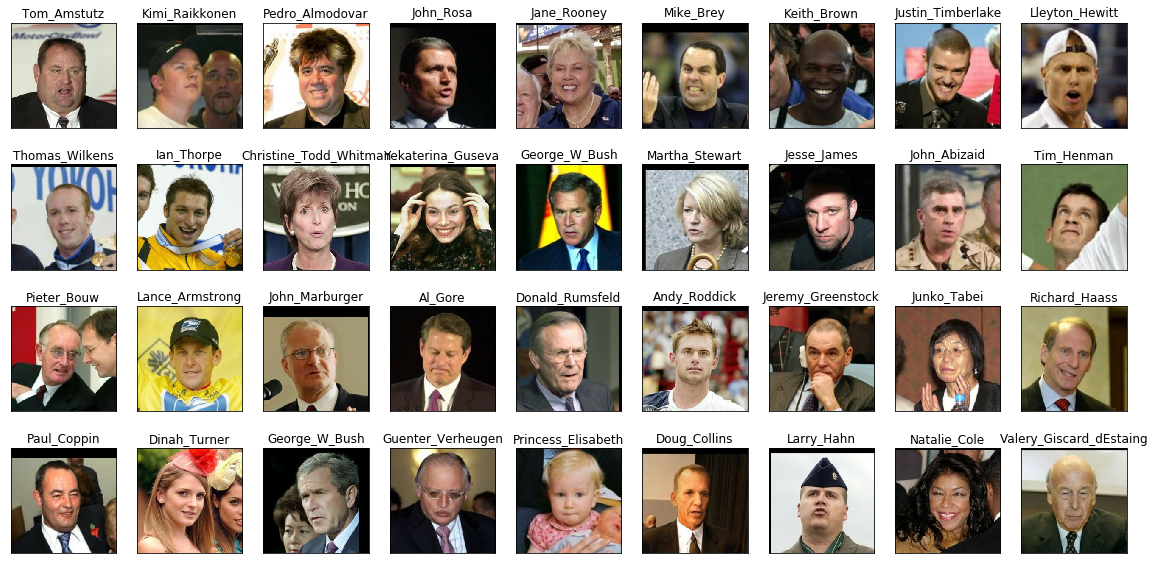

In [13]:
samples = [[x[0], x[1]] for x in iter(train_ds.take(36))]

fig = plt.figure(figsize=(20,10))

for i in range(len(samples)):
  ax = fig.add_subplot(4,9, i+1)
  ax.set_title(samples[i][0].numpy().decode('UTF-8'))
  ax.imshow(samples[i][1])
  plt.xticks([]), plt.yticks([])

plt.show()

### Создание модели CNN

In [6]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

### Contrastive Loss

In [7]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

### Подготовка пайплайна данных

In [8]:
def normal(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [9]:
BATCH_SIZE = 64
NUM_EPOCHS = 5

train_ds = train_ds.map(normal)
train_ds = train_ds.shuffle(buffer_size=11000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

### Обучение модели

In [10]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [11]:
for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 100 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 90.85687182617122
[100] Loss: 0.19128043413162221
[200] Loss: 0.002393249724060658
[300] Loss: 8.294175148010854
[400] Loss: 0.58496322870254521
[500] Loss: 0.0
[600] Loss: 0.39397974729537214
[700] Loss: 0.14371130287647295
[800] Loss: 0.024576174095273002
[900] Loss: 0.21390789818763963


## Тестирование на новых данных

In [12]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [13]:
!wget https://psj.ru/images/images/2020/04/01/801235587411.jpg
!wget https://www.vladtime.ru/uploads/posts/2017-12/1512580190_inx960x640-1.jpg
!wget https://krasavica.info/uploads/posts/2019-11/1573251558_devushka-s-glazami-cveta-neba-chastnoe-2019-86.jpg

--2020-08-13 22:18:22--  https://psj.ru/images/images/2020/04/01/801235587411.jpg
Resolving psj.ru (psj.ru)... 192.162.242.22
Connecting to psj.ru (psj.ru)|192.162.242.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276167 (270K) [image/jpeg]
Saving to: ‘801235587411.jpg’

801235587411.jpg    100%[===================>] 269.69K  --.-KB/s    in 0.1s    

2020-08-13 20:08:22 (2.00 MB/s) - ‘801235587411.jpg’ saved [276167/276167]

--2020-08-13 20:08:24--  https://www.vladtime.ru/uploads/posts/2017-12/1512580190_inx960x640-1.jpg
Resolving www.vladtime.ru (www.vladtime.ru)... 85.25.203.132
Connecting to www.vladtime.ru (www.vladtime.ru)|85.25.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124667 (122K) [image/jpeg]
Saving to: ‘1512580190_inx960x640-1.jpg’

1512580190_inx960x6 100%[===================>] 121.75K  --.-KB/s    in 0.02s   

2020-08-13 20:08:24 (5.32 MB/s) - ‘1512580190_inx960x640-1.jpg’ saved [124667/124667]

--2020-

In [14]:
def load_and_prepare_image(fpath):
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

In [15]:
img_a1 = load_and_prepare_image('801235587411.jpg') 
img_a2 = load_and_prepare_image('1512580190_inx960x640-1.jpg') 
img_b1 = load_and_prepare_image('1573251558_devushka-s-glazami-cveta-neba-chastnoe-2019-86.jpg') 

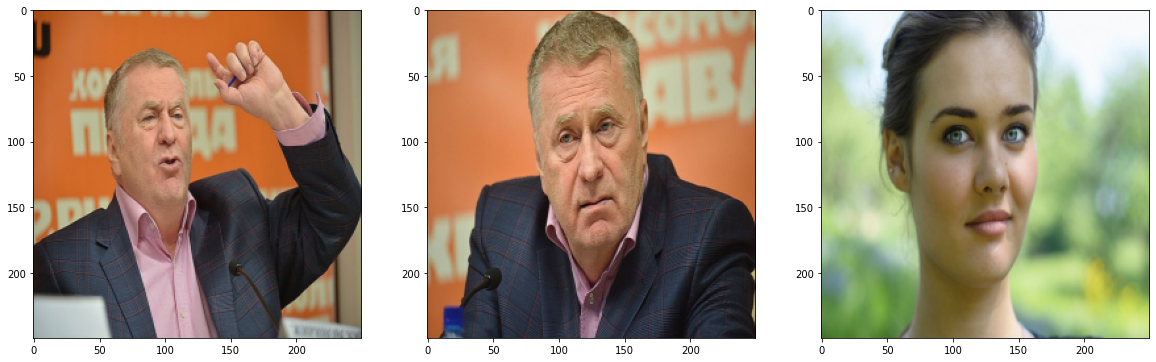

In [16]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)

ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)

ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1);

In [17]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

In [18]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  9.358712379624122
A2 <-> B1:  21.10782629937412
A1 <-> B1:  18.87584935149532


**Вывод**

Формально данная сеть с задачей эммбендинга справилась, но результат в случае A1 <-> A2 имеет достаточно большое расстояние при условии, что это фотографии одного и того же человека. Возможность для повышения точности вижу в изменениях архитектуры слоёв нейронной сети и подбора более корректной функции loss.